# NDS Ablation: Scalar Initializations x Signed Nonlinearities on 1-WL-Equivalent Graph Pairs

**Full ablation experiment** testing 8 scalar initializations x 4 nonlinearities x T=1..T_MAX diffusion steps on provably 1-WL-equivalent graph pairs.

**Key question:** Does applying pointwise nonlinearity (tanh, leaky ReLU, abs) between diffusion steps create cross-frequency coupling that breaks spectral invariance, enabling discrimination of 1-WL-equivalent graphs that linear diffusion alone cannot?

**Key finding:** `HYPOTHESIS_FALSIFIED_VERTEX_TRANSITIVITY` — all deterministic scalar node features are constant on vertex-transitive SRG/CSL graphs, so nonlinear diffusion provides zero additional discriminative power over linear diffusion (gap=0 for all init x nonlinearity combinations).

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT on Colab, always install
_pip('loguru==0.7.3')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'networkx==3.6.1', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import sys
import time
from pathlib import Path

import networkx as nx
import numpy as np
from loguru import logger
from scipy.spatial.distance import cdist

# Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate

## Data Loading

Load graph pairs from GitHub (or local fallback). Each example contains two 1-WL-equivalent graph adjacency matrices.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter3_nds_ablation_sc/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'][0]['examples'])} graph pairs")
for ex in data['datasets'][0]['examples']:
    inp = json.loads(ex['input'])
    print(f"  {inp['pair_id']}: {inp['graph_a']['name']} vs {inp['graph_b']['name']} (n={inp['graph_a']['num_nodes']})")

Loaded 3 graph pairs
  srg16_rook_vs_shrikhande: Rook_4x4 vs Shrikhande (n=16)
  srg25_paulus_g1_vs_g2: Paulus25_graph1 vs Paulus25_graph2 (n=25)
  srg25_paulus_g1_vs_g3: Paulus25_graph1 vs Paulus25_graph3 (n=25)


## Configuration

Tunable parameters for the ablation experiment. Adjust `T_MAX` for number of diffusion steps and `INIT_NAMES` to control which initializations are tested.

In [5]:
# ── Tunable Parameters ──
T_MAX = 20  # Number of diffusion steps (original value)

DIST_THRESHOLD_ABS = 1e-8   # Absolute threshold for Frobenius distance
DIST_THRESHOLD_REL = 1e-10  # Relative threshold (distance / feature norm)

# Which initializations to run (all 8)
PRIMARY_INITS = ["degree", "clustering_coeff", "pagerank", "betweenness", "eigvec_centrality"]
FALLBACK_INITS = ["subgraph_centrality", "heat_kernel_diag", "multidim_powers"]

# T values sampled for output examples
T_SAMPLE = [1, 2, 3, 4, 5, 10, 15, 20]  # Original value

## Step 1: Parse Graph Pairs from Data

Extract adjacency matrices and build NetworkX graphs from the loaded JSON data.

In [6]:
def load_graph_pairs(data: dict) -> list:
    """Parse graph pairs from the loaded JSON data.

    Returns list of dicts with keys:
        pair_id, category, num_nodes, graph_a_nx, graph_b_nx,
        graph_a_adj, graph_b_adj, graph_a_name, graph_b_name
    """
    examples = data["datasets"][0]["examples"]
    logger.info(f"Found {len(examples)} graph pairs")

    pairs = []
    for ex in examples:
        inp = json.loads(ex["input"])
        pair_id = inp["pair_id"]
        category = inp["category"]

        ga_data = inp["graph_a"]
        gb_data = inp["graph_b"]

        adj_a = np.array(ga_data["adjacency_matrix"], dtype=np.float64)
        adj_b = np.array(gb_data["adjacency_matrix"], dtype=np.float64)

        G_a = nx.from_numpy_array(adj_a)
        G_b = nx.from_numpy_array(adj_b)

        pairs.append({
            "pair_id": pair_id,
            "category": category,
            "num_nodes": ga_data["num_nodes"],
            "graph_a_nx": G_a,
            "graph_b_nx": G_b,
            "graph_a_adj": adj_a,
            "graph_b_adj": adj_b,
            "graph_a_name": ga_data["name"],
            "graph_b_name": gb_data["name"],
        })
        logger.debug(
            f"  Loaded pair {pair_id}: {ga_data['name']} vs {gb_data['name']} "
            f"(n={ga_data['num_nodes']}, category={category})"
        )

    categories = sorted(set(p["category"] for p in pairs))
    logger.info(f"Loaded {len(pairs)} graph pairs across categories: {categories}")
    return pairs

pairs = load_graph_pairs(data)

2026-02-19 23:43:05.265 | INFO     | __main__:load_graph_pairs:9 - Found 3 graph pairs


2026-02-19 23:43:05.269 | DEBUG    | __main__:load_graph_pairs:37 -   Loaded pair srg16_rook_vs_shrikhande: Rook_4x4 vs Shrikhande (n=16, category=srg_16_6_2_2)


2026-02-19 23:43:05.272 | DEBUG    | __main__:load_graph_pairs:37 -   Loaded pair srg25_paulus_g1_vs_g2: Paulus25_graph1 vs Paulus25_graph2 (n=25, category=srg_25_12_5_6)


2026-02-19 23:43:05.277 | DEBUG    | __main__:load_graph_pairs:37 -   Loaded pair srg25_paulus_g1_vs_g3: Paulus25_graph1 vs Paulus25_graph3 (n=25, category=srg_25_12_5_6)


2026-02-19 23:43:05.279 | INFO     | __main__:load_graph_pairs:43 - Loaded 3 graph pairs across categories: ['srg_16_6_2_2', 'srg_25_12_5_6']


## Step 2: Initialization Functions

Define 8 scalar node feature initializations: 5 primary (degree, clustering, PageRank, betweenness, eigenvector centrality) and 3 fallback (subgraph centrality, heat kernel diagonal, multi-dimensional powers).

In [7]:
def init_degree(G: nx.Graph) -> np.ndarray:
    """Degree of each node."""
    return np.array([G.degree(v) for v in range(G.number_of_nodes())], dtype=np.float64)


def init_clustering_coefficient(G: nx.Graph) -> np.ndarray:
    """Local clustering coefficient of each node."""
    cc = nx.clustering(G)
    return np.array([cc[v] for v in range(G.number_of_nodes())], dtype=np.float64)


def init_pagerank(G: nx.Graph) -> np.ndarray:
    """PageRank centrality (alpha=0.85)."""
    pr = nx.pagerank(G, alpha=0.85)
    return np.array([pr[v] for v in range(G.number_of_nodes())], dtype=np.float64)


def init_betweenness_centrality(G: nx.Graph) -> np.ndarray:
    """Betweenness centrality."""
    bc = nx.betweenness_centrality(G)
    return np.array([bc[v] for v in range(G.number_of_nodes())], dtype=np.float64)


def init_eigenvector_centrality(G: nx.Graph) -> np.ndarray:
    """Eigenvector centrality with numpy fallback."""
    try:
        ec = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        logger.warning("Eigenvector centrality did not converge, using numpy fallback")
        A = nx.to_numpy_array(G)
        vals, vecs = np.linalg.eigh(A)
        ec_vec = np.abs(vecs[:, -1])
        ec = {v: float(ec_vec[v]) for v in range(G.number_of_nodes())}
    return np.array([ec[v] for v in range(G.number_of_nodes())], dtype=np.float64)


def _matrix_exp(M: np.ndarray) -> np.ndarray:
    """Compute matrix exponential via eigendecomposition (for symmetric matrices)."""
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    return eigenvectors @ np.diag(np.exp(eigenvalues)) @ eigenvectors.T


def init_subgraph_centrality(G: nx.Graph) -> np.ndarray:
    """Subgraph centrality: diagonal of e^A. May be constant on vertex-transitive graphs."""
    A = nx.to_numpy_array(G, dtype=np.float64)
    expA = _matrix_exp(A)
    return np.diag(expA).copy()


def init_heat_kernel_diag(G: nx.Graph, t: float = 1.0) -> np.ndarray:
    """Heat kernel diagonal: diag(e^{-tL}). May be constant on vertex-transitive graphs."""
    L = nx.laplacian_matrix(G).toarray().astype(np.float64)
    expL = _matrix_exp(-t * L)
    return np.diag(expL).copy()


def init_multidim_powers(G: nx.Graph) -> np.ndarray:
    """Multi-dimensional init: [A^2_{vv}, A^3_{vv}, A^4_{vv}, A^5_{vv}] per node.
    Returns the L2 norm of this 4-vector as a scalar per node."""
    A = nx.to_numpy_array(G, dtype=np.float64)
    A2 = A @ A
    A3 = A2 @ A
    A4 = A3 @ A
    A5 = A4 @ A
    features = np.stack([np.diag(A2), np.diag(A3), np.diag(A4), np.diag(A5)], axis=1)
    return np.linalg.norm(features, axis=1)


INIT_FUNCTIONS = {
    "degree": init_degree,
    "clustering_coeff": init_clustering_coefficient,
    "pagerank": init_pagerank,
    "betweenness": init_betweenness_centrality,
    "eigvec_centrality": init_eigenvector_centrality,
    "subgraph_centrality": init_subgraph_centrality,
    "heat_kernel_diag": init_heat_kernel_diag,
    "multidim_powers": init_multidim_powers,
}

print(f"Defined {len(INIT_FUNCTIONS)} initialization functions: {list(INIT_FUNCTIONS.keys())}")

Defined 8 initialization functions: ['degree', 'clustering_coeff', 'pagerank', 'betweenness', 'eigvec_centrality', 'subgraph_centrality', 'heat_kernel_diag', 'multidim_powers']


## Step 3: Nonlinearity Functions

Four pointwise nonlinearities: identity (linear baseline), tanh, leaky ReLU (alpha=0.2), and absolute value.

In [8]:
def nl_linear(x: np.ndarray) -> np.ndarray:
    """Identity (baseline - no nonlinearity)."""
    return x


def nl_tanh(x: np.ndarray) -> np.ndarray:
    """Hyperbolic tangent."""
    return np.tanh(x)


def nl_leaky_relu(x: np.ndarray, alpha: float = 0.2) -> np.ndarray:
    """Leaky ReLU with slope alpha for negative values."""
    return np.where(x >= 0, x, alpha * x)


def nl_abs(x: np.ndarray) -> np.ndarray:
    """Absolute value."""
    return np.abs(x)


NONLINEARITIES = {
    "linear": nl_linear,
    "tanh": nl_tanh,
    "leaky_relu": nl_leaky_relu,
    "abs": nl_abs,
}

print(f"Defined {len(NONLINEARITIES)} nonlinearities: {list(NONLINEARITIES.keys())}")

Defined 4 nonlinearities: ['linear', 'tanh', 'leaky_relu', 'abs']


## Step 4: NDS Feature Computation

Compute Nonlinear Diffusion Signatures by iteratively applying normalized adjacency diffusion followed by a pointwise nonlinearity. The trajectory `x(t)` captures how node features evolve over diffusion steps.

In [9]:
def build_normalized_adjacency(G: nx.Graph) -> np.ndarray:
    """Build D^{-1/2} A D^{-1/2} normalized adjacency matrix."""
    A = nx.to_numpy_array(G, dtype=np.float64)
    degrees = A.sum(axis=1)
    D_inv_sqrt = np.diag(np.where(degrees > 0, 1.0 / np.sqrt(degrees), 0.0))
    return D_inv_sqrt @ A @ D_inv_sqrt


def compute_nds_features(
    A_norm: np.ndarray,
    x0: np.ndarray,
    nonlinearity_fn,
    T_max: int = T_MAX,
) -> np.ndarray:
    """Compute Nonlinear Diffusion Signatures for a graph.

    Args:
        A_norm: Normalized adjacency matrix (precomputed)
        x0: Initial scalar features per node
        nonlinearity_fn: Pointwise nonlinearity to apply after each diffusion step
        T_max: Maximum number of diffusion steps

    Returns:
        trajectory: np.ndarray of shape (n, T_max+1)
    """
    n = A_norm.shape[0]
    trajectory = np.zeros((n, T_max + 1), dtype=np.float64)
    x = x0.copy()
    trajectory[:, 0] = x

    for t in range(1, T_max + 1):
        x = A_norm @ x
        x = nonlinearity_fn(x)
        trajectory[:, t] = x

    return trajectory

print("NDS feature computation functions defined.")

NDS feature computation functions defined.


## Step 5: Distinguishability Metrics

Compare sorted NDS feature vectors between graph pairs using Frobenius distance and Maximum Mean Discrepancy (MMD) with RBF kernel. Both absolute and relative thresholds filter floating-point noise.

In [10]:
def _compute_mmd(feat_a: np.ndarray, feat_b: np.ndarray) -> float:
    """Maximum Mean Discrepancy with RBF kernel."""
    D_aa = cdist(feat_a, feat_a, "euclidean")
    D_bb = cdist(feat_b, feat_b, "euclidean")
    D_ab = cdist(feat_a, feat_b, "euclidean")

    all_dists = np.concatenate([D_aa.ravel(), D_bb.ravel(), D_ab.ravel()])
    sigma = float(np.median(all_dists))
    if sigma < 1e-12:
        sigma = 1.0

    K_aa = np.exp(-D_aa**2 / (2 * sigma**2))
    K_bb = np.exp(-D_bb**2 / (2 * sigma**2))
    K_ab = np.exp(-D_ab**2 / (2 * sigma**2))

    mmd_sq = K_aa.mean() + K_bb.mean() - 2 * K_ab.mean()
    return float(np.sqrt(max(0.0, mmd_sq)))


def compute_multiset_distance(
    traj_a: np.ndarray,
    traj_b: np.ndarray,
    T: int,
) -> tuple:
    """Check if sorted NDS feature vectors at step T are different.

    Returns:
        (is_distinguished, frobenius_distance, mmd, numerically_marginal)
    """
    feat_a = traj_a[:, :T + 1]
    feat_b = traj_b[:, :T + 1]

    # Sort rows lexicographically for multiset comparison
    sorted_a = feat_a[np.lexsort(feat_a.T[::-1])]
    sorted_b = feat_b[np.lexsort(feat_b.T[::-1])]

    frobenius = float(np.linalg.norm(sorted_a - sorted_b, "fro"))

    # Use both absolute and relative thresholds to handle numerical noise
    feature_norm = max(
        float(np.linalg.norm(sorted_a, "fro")),
        float(np.linalg.norm(sorted_b, "fro")),
        1e-15,
    )
    relative_dist = frobenius / feature_norm
    is_distinguished = (frobenius > DIST_THRESHOLD_ABS) and (relative_dist > DIST_THRESHOLD_REL)

    # MMD with RBF kernel
    mmd = _compute_mmd(feat_a, feat_b)

    # Flag numerically marginal cases
    numerically_marginal = (frobenius > 1e-12) and (relative_dist < 1e-6)

    return is_distinguished, frobenius, mmd, numerically_marginal

print("Distinguishability metric functions defined.")

Distinguishability metric functions defined.


## Step 6: Run Full Ablation Grid

Iterate over all combinations: graph pairs x initializations x nonlinearities x diffusion steps T=1..T_MAX.

In [11]:
def run_ablation_grid(
    pairs: list,
    init_names: list,
    T_max: int = T_MAX,
) -> list:
    """Run full ablation grid: inits x nonlinearities x T x pairs.

    Returns list of result dicts.
    """
    total_configs = len(init_names) * len(NONLINEARITIES) * T_max * len(pairs)
    logger.info(
        f"Running ablation grid: {len(init_names)} inits x "
        f"{len(NONLINEARITIES)} nonlinearities x T=1..{T_max} x "
        f"{len(pairs)} pairs = {total_configs} evaluations"
    )

    results = []
    config_count = 0

    for pair_idx, pair in enumerate(pairs):
        G_a = pair["graph_a_nx"]
        G_b = pair["graph_b_nx"]
        pair_id = pair["pair_id"]
        category = pair["category"]

        # Precompute normalized adjacencies
        A_norm_a = build_normalized_adjacency(G_a)
        A_norm_b = build_normalized_adjacency(G_b)

        for init_name in init_names:
            init_fn = INIT_FUNCTIONS[init_name]

            # Check: are init features identical for this pair?
            feat_a_init = init_fn(G_a)
            feat_b_init = init_fn(G_b)
            init_identical = bool(
                np.allclose(np.sort(feat_a_init), np.sort(feat_b_init), atol=1e-10)
            )

            # Check if init is constant per graph (vertex-transitive indicator)
            a_const = bool(np.allclose(feat_a_init, feat_a_init[0], atol=1e-10))
            b_const = bool(np.allclose(feat_b_init, feat_b_init[0], atol=1e-10))
            init_is_constant = a_const and b_const

            for nl_name, nl_fn in NONLINEARITIES.items():
                t_start = time.time()

                traj_a = compute_nds_features(
                    A_norm=A_norm_a,
                    x0=feat_a_init,
                    nonlinearity_fn=nl_fn,
                    T_max=T_max,
                )
                traj_b = compute_nds_features(
                    A_norm=A_norm_b,
                    x0=feat_b_init,
                    nonlinearity_fn=nl_fn,
                    T_max=T_max,
                )

                wall_clock = time.time() - t_start

                for T in range(1, T_max + 1):
                    is_dist, frob, mmd, marginal = compute_multiset_distance(
                        traj_a, traj_b, T
                    )

                    results.append({
                        "pair_id": pair_id,
                        "category": category,
                        "num_nodes": pair["num_nodes"],
                        "init": init_name,
                        "nonlinearity": nl_name,
                        "T": T,
                        "distinguished": is_dist,
                        "frobenius_distance": frob,
                        "mmd": mmd,
                        "numerically_marginal": marginal,
                        "init_features_identical": init_identical,
                        "init_is_constant": init_is_constant,
                        "wall_clock_s": wall_clock,
                    })

                config_count += T_max

        logger.info(
            f"  Pair {pair_idx + 1}/{len(pairs)} done: {pair_id} "
            f"({config_count}/{total_configs} configs)"
        )

    logger.info(f"Ablation grid complete: {len(results)} results")
    return results

overall_start = time.time()

# Phase 1: Primary ablation grid
print("=" * 60)
print("PHASE 1: Primary ablation grid")
print("=" * 60)
primary_results = run_ablation_grid(
    pairs=pairs,
    init_names=PRIMARY_INITS,
    T_max=T_MAX,
)

# Phase 2: Fallback ablation grid
print("=" * 60)
print("PHASE 2: Fallback ablation grid")
print("=" * 60)
fallback_results = run_ablation_grid(
    pairs=pairs,
    init_names=FALLBACK_INITS,
    T_max=T_MAX,
)

# Combine all results
all_results = primary_results + fallback_results
all_init_names = PRIMARY_INITS + FALLBACK_INITS
print(f"\nTotal results: {len(all_results)}")

2026-02-19 23:43:05.395 | INFO     | __main__:run_ablation_grid:11 - Running ablation grid: 5 inits x 4 nonlinearities x T=1..20 x 3 pairs = 1200 evaluations


PHASE 1: Primary ablation grid


2026-02-19 23:43:05.732 | INFO     | __main__:run_ablation_grid:86 -   Pair 1/3 done: srg16_rook_vs_shrikhande (400/1200 configs)


2026-02-19 23:43:06.079 | INFO     | __main__:run_ablation_grid:86 -   Pair 2/3 done: srg25_paulus_g1_vs_g2 (800/1200 configs)


2026-02-19 23:43:06.311 | INFO     | __main__:run_ablation_grid:86 -   Pair 3/3 done: srg25_paulus_g1_vs_g3 (1200/1200 configs)


2026-02-19 23:43:06.312 | INFO     | __main__:run_ablation_grid:91 - Ablation grid complete: 1200 results


2026-02-19 23:43:06.313 | INFO     | __main__:run_ablation_grid:11 - Running ablation grid: 3 inits x 4 nonlinearities x T=1..20 x 3 pairs = 720 evaluations


2026-02-19 23:43:06.398 | INFO     | __main__:run_ablation_grid:86 -   Pair 1/3 done: srg16_rook_vs_shrikhande (240/720 configs)


PHASE 2: Fallback ablation grid


2026-02-19 23:43:06.545 | INFO     | __main__:run_ablation_grid:86 -   Pair 2/3 done: srg25_paulus_g1_vs_g2 (480/720 configs)


2026-02-19 23:43:06.925 | INFO     | __main__:run_ablation_grid:86 -   Pair 3/3 done: srg25_paulus_g1_vs_g3 (720/720 configs)


2026-02-19 23:43:06.960 | INFO     | __main__:run_ablation_grid:91 - Ablation grid complete: 720 results



Total results: 1920


## Step 7: Gap Analysis (Nonlinear vs Linear)

For each init x nonlinearity pair, count how many graph pairs are distinguished by the nonlinear method but NOT by linear diffusion (positive gap). This is the core hypothesis test.

In [12]:
def compute_gap_analysis(
    results: list,
    pairs: list,
    init_names: list,
) -> dict:
    """Compute gap between nonlinear and linear distinguishability."""
    gap_analysis = {}

    for init_name in init_names:
        for nl_name in [n for n in NONLINEARITIES if n != "linear"]:
            key = f"{init_name}__{nl_name}"
            gap_entry = {
                "pairs_distinguished_nonlinear": 0,
                "pairs_distinguished_linear": 0,
                "positive_gap_pairs": [],
                "negative_gap_pairs": [],
                "same_pairs": [],
            }

            for pair in pairs:
                pid = pair["pair_id"]

                nl_results = [
                    r for r in results
                    if r["init"] == init_name
                    and r["nonlinearity"] == nl_name
                    and r["pair_id"] == pid
                ]
                any_nl_dist = any(r["distinguished"] for r in nl_results)

                lin_results = [
                    r for r in results
                    if r["init"] == init_name
                    and r["nonlinearity"] == "linear"
                    and r["pair_id"] == pid
                ]
                any_lin_dist = any(r["distinguished"] for r in lin_results)

                if any_nl_dist:
                    gap_entry["pairs_distinguished_nonlinear"] += 1
                if any_lin_dist:
                    gap_entry["pairs_distinguished_linear"] += 1
                if any_nl_dist and not any_lin_dist:
                    gap_entry["positive_gap_pairs"].append(pid)
                elif any_lin_dist and not any_nl_dist:
                    gap_entry["negative_gap_pairs"].append(pid)
                else:
                    gap_entry["same_pairs"].append(pid)

            gap_analysis[key] = gap_entry

    return gap_analysis

gap_analysis = compute_gap_analysis(
    results=all_results,
    pairs=pairs,
    init_names=all_init_names,
)

# Check for any positive gap
any_positive = any(
    len(g["positive_gap_pairs"]) > 0 for g in gap_analysis.values()
)
print(f"Any positive gap found: {any_positive}")

# Determine hypothesis verdict
all_primary_constant = all(
    r["init_is_constant"]
    for r in all_results
    if r["init"] in PRIMARY_INITS and r["T"] == 1
)

if any_positive:
    verdict = "MODE_COUPLING_VALIDATED"
elif all_primary_constant:
    verdict = "HYPOTHESIS_FALSIFIED_VERTEX_TRANSITIVITY"
else:
    verdict = "HYPOTHESIS_FALSIFIED"

print(f"Hypothesis verdict: {verdict}")

Any positive gap found: False
Hypothesis verdict: HYPOTHESIS_FALSIFIED_VERTEX_TRANSITIVITY


## Step 8: Build Summary Tables

Aggregate results into per-init and per-nonlinearity summaries showing how many pairs each combination distinguishes.

In [13]:
def build_per_init_summary(
    results: list,
    pairs: list,
    init_names: list,
) -> dict:
    """Per-init summary: how many pairs distinguished with each nonlinearity."""
    summary = {}
    for init_name in init_names:
        init_summary = {}
        for nl_name in NONLINEARITIES:
            distinguished_pairs = []
            for pair in pairs:
                pid = pair["pair_id"]
                pair_results = [
                    r for r in results
                    if r["init"] == init_name
                    and r["nonlinearity"] == nl_name
                    and r["pair_id"] == pid
                ]
                if any(r["distinguished"] for r in pair_results):
                    first_T = min(
                        r["T"] for r in pair_results if r["distinguished"]
                    )
                    best_frob = max(r["frobenius_distance"] for r in pair_results)
                    distinguished_pairs.append({
                        "pair_id": pid,
                        "first_T": first_T,
                        "best_frobenius": best_frob,
                    })

            init_summary[nl_name] = {
                "num_distinguished": len(distinguished_pairs),
                "distinguished_pairs": distinguished_pairs,
            }
        summary[init_name] = init_summary
    return summary


def build_per_nonlinearity_summary(
    results: list,
    pairs: list,
    init_names: list,
) -> dict:
    """Per-nonlinearity summary: total pairs distinguished across all inits."""
    summary = {}
    for nl_name in NONLINEARITIES:
        total_dist = 0
        frob_values = []
        for init_name in init_names:
            for pair in pairs:
                pid = pair["pair_id"]
                pair_results = [
                    r for r in results
                    if r["init"] == init_name
                    and r["nonlinearity"] == nl_name
                    and r["pair_id"] == pid
                ]
                if any(r["distinguished"] for r in pair_results):
                    total_dist += 1
                    frob_values.append(
                        max(r["frobenius_distance"] for r in pair_results)
                    )

        summary[nl_name] = {
            "total_distinguished_init_pair_combos": total_dist,
            "mean_frobenius": float(np.mean(frob_values)) if frob_values else 0.0,
            "max_frobenius": float(np.max(frob_values)) if frob_values else 0.0,
        }
    return summary


per_init_summary = build_per_init_summary(
    results=all_results,
    pairs=pairs,
    init_names=all_init_names,
)
per_nonlinearity_summary = build_per_nonlinearity_summary(
    results=all_results,
    pairs=pairs,
    init_names=all_init_names,
)

total_wall_clock = time.time() - overall_start
print(f"Total wall clock: {total_wall_clock:.2f}s")

Total wall clock: 1.82s


## Results Visualization

### Summary Tables and Heatmap

Display the ablation results: per-initialization distinguishability counts, per-nonlinearity summary, and a heatmap showing the number of pairs distinguished by each init x nonlinearity combination.

HYPOTHESIS VERDICT: HYPOTHESIS_FALSIFIED_VERTEX_TRANSITIVITY
Total wall clock: 1.82s
Total results: 1920
Graph pairs: 3
T_MAX: 20

Pairs Distinguished (at any T):
+---------------------+----------+--------+--------------+-------+
| Init \ NL           | linear   | tanh   | leaky_relu   | abs   |
+=====================+==========+========+==============+=======+
| degree              | 0/3      | 0/3    | 0/3          | 0/3   |
+---------------------+----------+--------+--------------+-------+
| clustering_coeff    | 0/3      | 0/3    | 0/3          | 0/3   |
+---------------------+----------+--------+--------------+-------+
| pagerank            | 0/3      | 0/3    | 0/3          | 0/3   |
+---------------------+----------+--------+--------------+-------+
| betweenness         | 0/3      | 0/3    | 0/3          | 0/3   |
+---------------------+----------+--------+--------------+-------+
| eigvec_centrality   | 0/3      | 0/3    | 0/3          | 0/3   |
+---------------------+----------

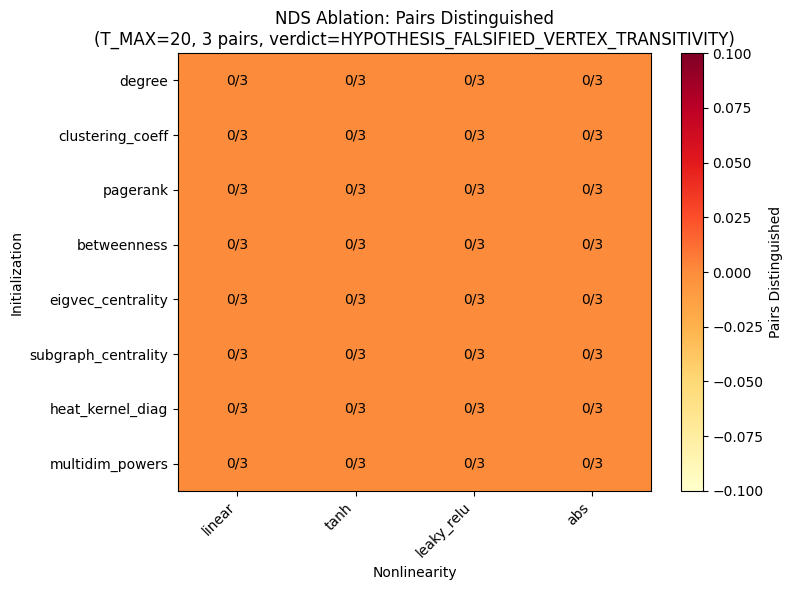


Heatmap saved to nds_ablation_heatmap.png


In [14]:
# ── Table 1: Per-Init x Nonlinearity Distinguishability ──
print("=" * 60)
print(f"HYPOTHESIS VERDICT: {verdict}")
print(f"Total wall clock: {total_wall_clock:.2f}s")
print(f"Total results: {len(all_results)}")
print(f"Graph pairs: {len(pairs)}")
print(f"T_MAX: {T_MAX}")
print("=" * 60)

# Build heatmap data
nl_names = list(NONLINEARITIES.keys())
table_data = []
heatmap_matrix = np.zeros((len(all_init_names), len(nl_names)), dtype=int)

for i, init_name in enumerate(all_init_names):
    row = [init_name]
    for j, nl_name in enumerate(nl_names):
        count = per_init_summary[init_name][nl_name]["num_distinguished"]
        row.append(f"{count}/{len(pairs)}")
        heatmap_matrix[i, j] = count
    table_data.append(row)

headers = ["Init \\ NL"] + nl_names
print("\nPairs Distinguished (at any T):")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# ── Table 2: Per-Nonlinearity Summary ──
print("\nPer-Nonlinearity Summary:")
nl_table = []
for nl_name in nl_names:
    s = per_nonlinearity_summary[nl_name]
    nl_table.append([
        nl_name,
        s["total_distinguished_init_pair_combos"],
        f"{s['mean_frobenius']:.4f}",
        f"{s['max_frobenius']:.4f}",
    ])
print(tabulate(
    nl_table,
    headers=["Nonlinearity", "Total Dist", "Mean Frob", "Max Frob"],
    tablefmt="grid",
))

# ── Table 3: Gap Analysis Summary ──
print("\nGap Analysis (Nonlinear vs Linear):")
gap_table = []
for key, g in gap_analysis.items():
    gap_table.append([
        key,
        g["pairs_distinguished_nonlinear"],
        g["pairs_distinguished_linear"],
        len(g["positive_gap_pairs"]),
        len(g["negative_gap_pairs"]),
    ])
print(tabulate(
    gap_table,
    headers=["Config", "NL Dist", "Lin Dist", "+Gap", "-Gap"],
    tablefmt="grid",
))

# ── Heatmap: Init x Nonlinearity ──
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap_matrix, cmap="YlOrRd", aspect="auto")

ax.set_xticks(range(len(nl_names)))
ax.set_xticklabels(nl_names, rotation=45, ha="right")
ax.set_yticks(range(len(all_init_names)))
ax.set_yticklabels(all_init_names)

# Annotate cells
for i in range(len(all_init_names)):
    for j in range(len(nl_names)):
        text = ax.text(
            j, i, f"{heatmap_matrix[i, j]}/{len(pairs)}",
            ha="center", va="center", fontsize=10,
            color="white" if heatmap_matrix[i, j] > len(pairs) * 0.5 else "black",
        )

ax.set_title(
    f"NDS Ablation: Pairs Distinguished\n"
    f"(T_MAX={T_MAX}, {len(pairs)} pairs, verdict={verdict})"
)
ax.set_xlabel("Nonlinearity")
ax.set_ylabel("Initialization")

plt.colorbar(im, ax=ax, label="Pairs Distinguished")
plt.tight_layout()
plt.savefig("nds_ablation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nHeatmap saved to nds_ablation_heatmap.png")